In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from datetime import datetime, timedelta
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
### Prepare data
# load S&P500 price data since 1950:
os.chdir('/home/roman/Documents/Projects/Bubbles')
sp_original = pd.read_csv('^GSPC.csv', index_col = 'Date')
sp_original.index = pd.to_datetime(sp_original.index, format='%Y/%m/%d')
sp_norm = sp_original['Close'] / sp_original['Close'][-1]
sp_ch = sp_original['Close'].pct_change()
window = 10
sp_vol = sp_original['Close'].pct_change().rolling(window).std()
sp = pd.concat([sp_original['Close'], sp_norm, sp_ch, sp_vol], axis=1).dropna()
sp.columns = ['price', 'norm', 'ch', 'vol']

### find drawdowns (consecutive price decreases)
pmin_pmax = (sp['price'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
pmax = pmin_pmax[pmin_pmax == 1]
pmin = pmin_pmax[pmin_pmax == -1]
# make sure drawdowns start with pmax, end with pmin:
if pmin.index[0] < pmax.index[0]:
    pmin = pmin.drop(pmin.index[0])
if pmin.index[-1] < pmax.index[-1]:
    pmax = pmax.drop(pmax.index[-1])
D = (np.array(sp['price'][pmin.index]) - np.array(sp['price'][pmax.index])) \
    / np.array(sp['price'][pmax.index])
d = {'Date':pmax.index, 'drawdown':D, 'd_start': pmax.index, 'd_end': pmin.index}    
df = pd.DataFrame(d).set_index('Date')
df.index = pd.to_datetime(df.index, format='%Y/%m/%d')
df = df.reindex(sp.index).fillna(0)

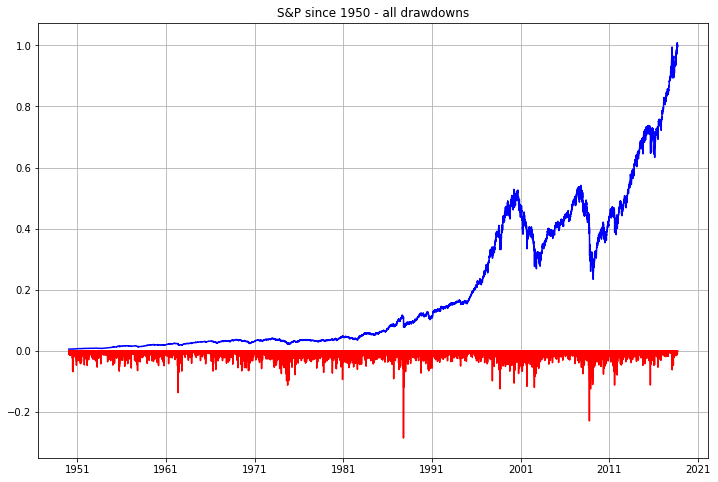

In [3]:
# plot S&P since 1951 with all drawdowns:
rcParams['figure.figsize'] = 12, 8
plt.plot(sp['norm'], color='blue')
plt.plot(df['drawdown'], color='red')
plt.title('S&P since 1950 - all drawdowns')
plt.grid()
plt.show()

In [4]:
# Identify crashes (lidentify crashes: >10.5% drawdown)
df = df.sort_values(by='drawdown')
df['rank'] = list(range(1,df.shape[0]+1))
df = df.sort_values(by='Date')
df_c = df[df['drawdown'] < -0.105]
df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'rank']
print(df_c)
c_st = list(df_c['crash_st'])
d_st = [sp['price'][(c_s-timedelta(int(252*5/12))):c_s].idxmax() for c_s in c_st]
d_st_adj = [max(d, c_prev) for d, c_prev in zip(d_st[1:], c_st[:-1])]
d_st_adj = [d_st[0]] + d_st_adj

df_c['down_st'] = d_st_adj

            drawdown             crash_st            crash_end  rank
Date                                                                
1962-05-15 -0.136724  1962-05-15 00:00:00  1962-05-28 00:00:00     3
1974-09-20 -0.112062  1974-09-20 00:00:00  1974-10-03 00:00:00     9
1987-10-13 -0.285133  1987-10-13 00:00:00  1987-10-19 00:00:00     1
1987-10-21 -0.118856  1987-10-21 00:00:00  1987-10-26 00:00:00     7
1998-08-25 -0.124052  1998-08-25 00:00:00  1998-08-31 00:00:00     5
2000-04-07 -0.105378  2000-04-07 00:00:00  2000-04-14 00:00:00    13
2001-09-10 -0.116005  2001-09-10 00:00:00  2001-09-21 00:00:00     8
2002-07-17 -0.119575  2002-07-17 00:00:00  2002-07-23 00:00:00     6
2008-09-30 -0.229037  2008-09-30 00:00:00  2008-10-10 00:00:00     2
2008-11-18 -0.124174  2008-11-18 00:00:00  2008-11-20 00:00:00     4
2009-02-12 -0.109987  2009-02-12 00:00:00  2009-02-23 00:00:00    12
2011-08-03 -0.111779  2011-08-03 00:00:00  2011-08-08 00:00:00    10
2015-08-17 -0.111694  2015-08-17 0

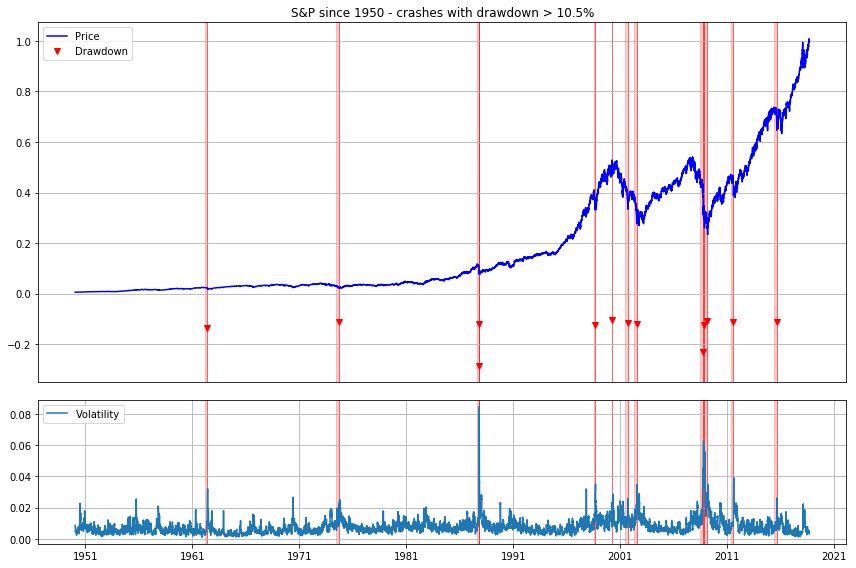

In [5]:
# plot prices, crashes, volatility since 1950
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
plt.subplot(gs[0])
plt.plot(sp['norm'], color='blue')
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(df_c['down_st'], \
     df_c['crash_st'])]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(df_c['crash_st'], \
     df_c['crash_end'])]
plt.plot(df_c['drawdown'], color='red', marker='v',linestyle='')
plt.title('S&P since 1950 - crashes with drawdown > 10.5%')
plt.grid()
plt.xticks([])
plt.legend(['Price', 'Drawdown'])
plt.subplot(gs[1])
plt.plot(sp['vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(df_c['down_st'], \
     df_c['crash_st'])]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(df_c['crash_st'], \
     df_c['crash_end'])]
plt.legend(['Volatility'])
plt.grid()
plt.tight_layout()
plt.show()

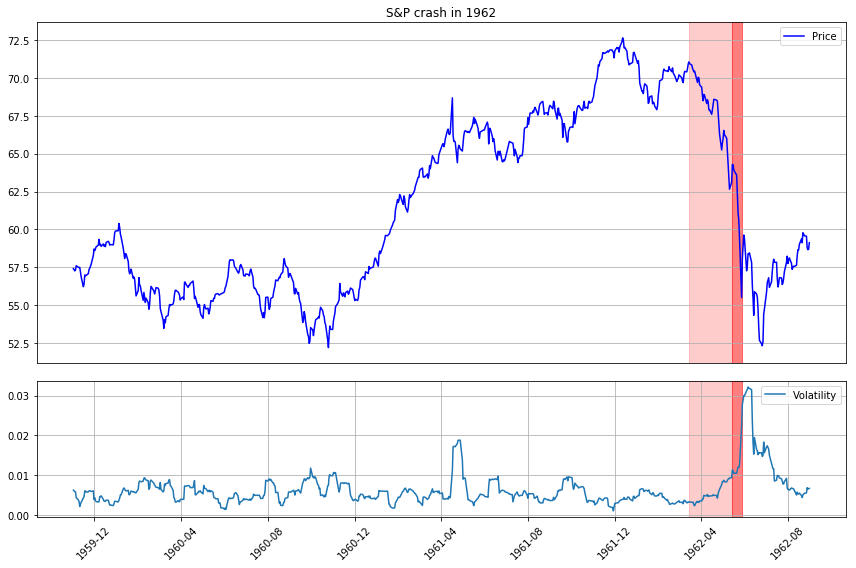

In [6]:
# 1962:
plt.subplot(gs[0])
t1 = datetime.strptime('1959-11-01', '%Y-%m-%d')
t2 = datetime.strptime('1962-08-31', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.plot(sp.loc[t1:t2, 'price'], color='blue')
plt.title('S&P crash in 1962')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

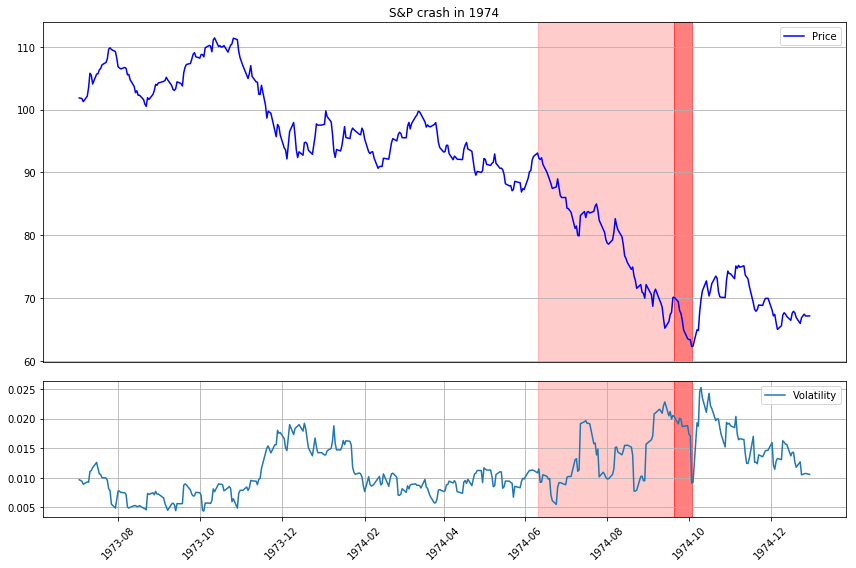

In [7]:
# 1974:
plt.subplot(gs[0])
t1 = datetime.strptime('1973-07-03', '%Y-%m-%d')
t2 = datetime.strptime('1974-12-30', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.plot(sp.loc[t1:t2, 'price'], color='blue')
plt.title('S&P crash in 1974')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

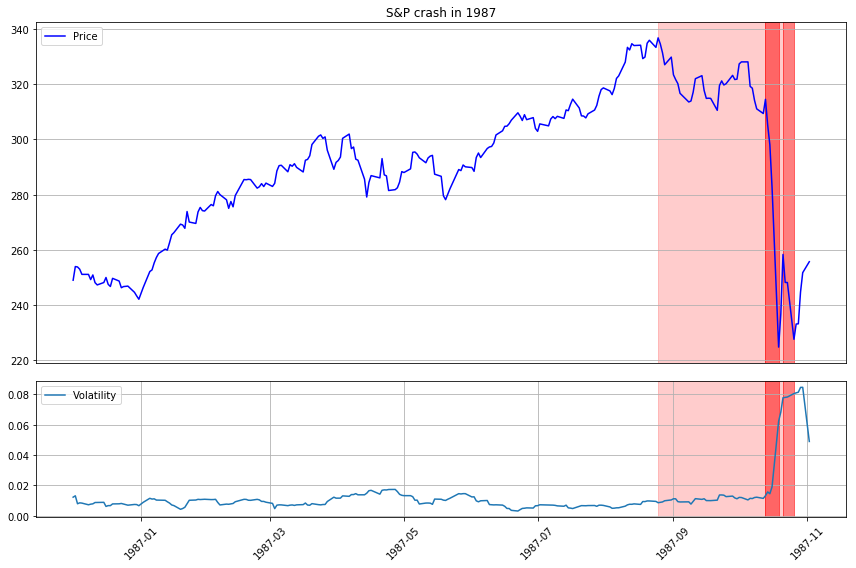

In [8]:
# 1987:
plt.subplot(gs[0])
t1 = datetime.strptime('1986-12-01', '%Y-%m-%d')
t2 = datetime.strptime('1987-11-02', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.plot(sp.loc[t1:t2, 'price'], color='blue')
plt.title('S&P crash in 1987')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

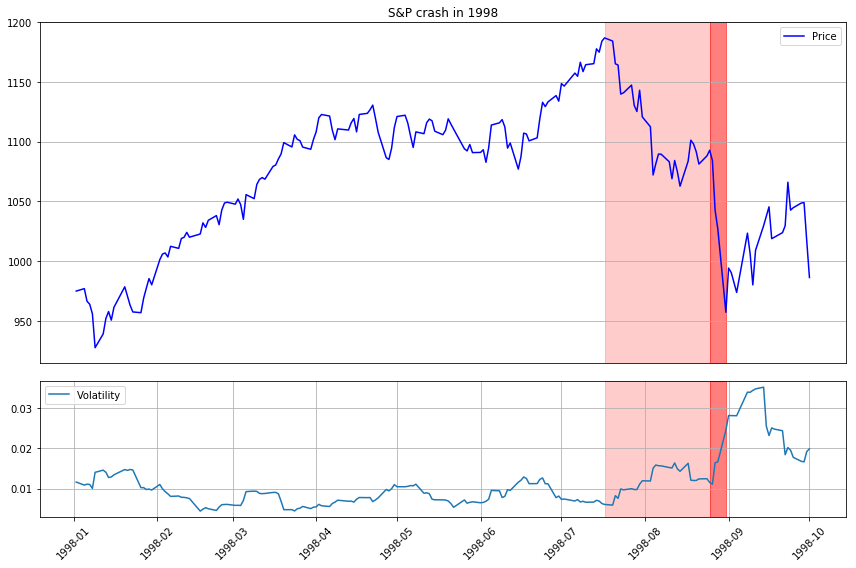

In [9]:
# 1998:
plt.subplot(gs[0])
t1 = datetime.strptime('1998-01-01', '%Y-%m-%d')
t2 = datetime.strptime('1998-10-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.plot(sp.loc[t1:t2, 'price'], color='blue')
plt.title('S&P crash in 1998')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

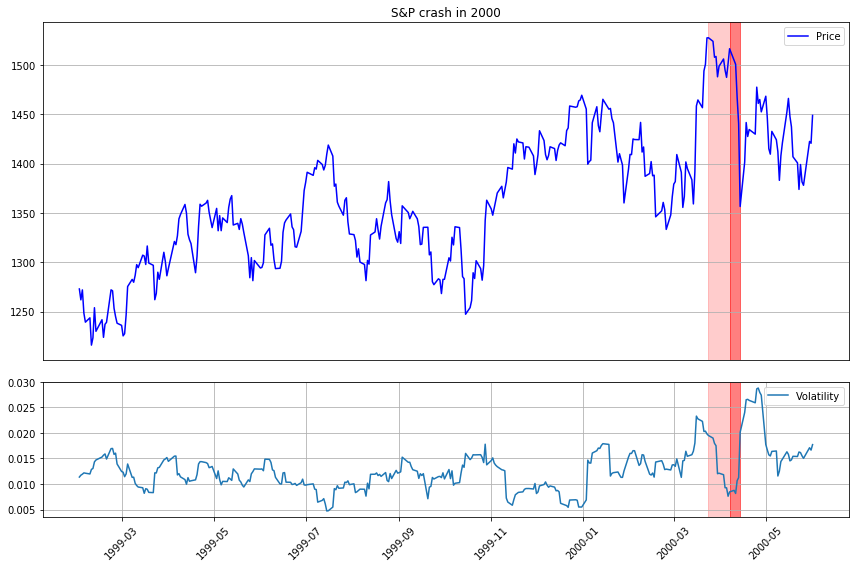

In [10]:
#2000
plt.subplot(gs[0])
t1 = datetime.strptime('1999-02-01', '%Y-%m-%d')
t2 = datetime.strptime('2000-06-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.plot(sp.loc[t1:t2, 'price'], color='blue')
plt.title('S&P crash in 2000')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

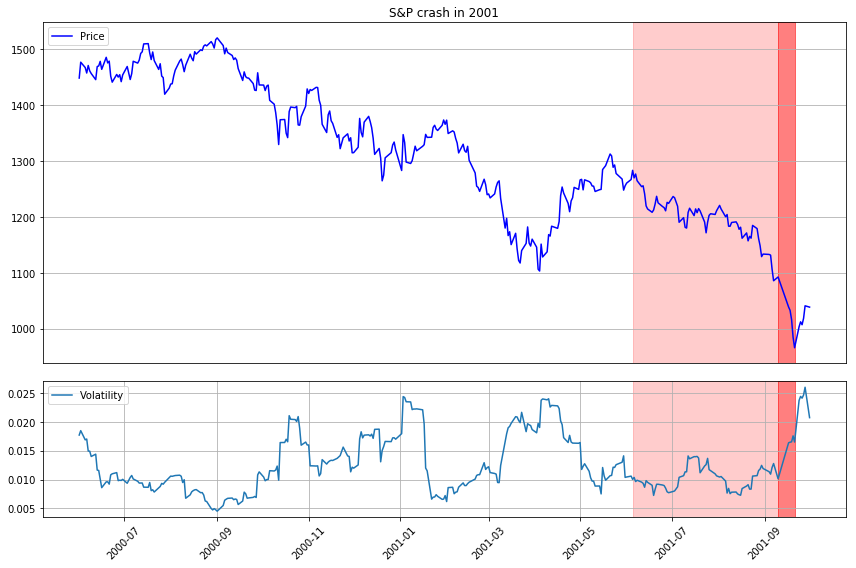

In [11]:
#2001
plt.subplot(gs[0])
t1 = datetime.strptime('2000-06-01', '%Y-%m-%d')
t2 = datetime.strptime('2001-10-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.plot(sp.loc[t1:t2, 'price'], color='blue')
plt.title('S&P crash in 2001')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

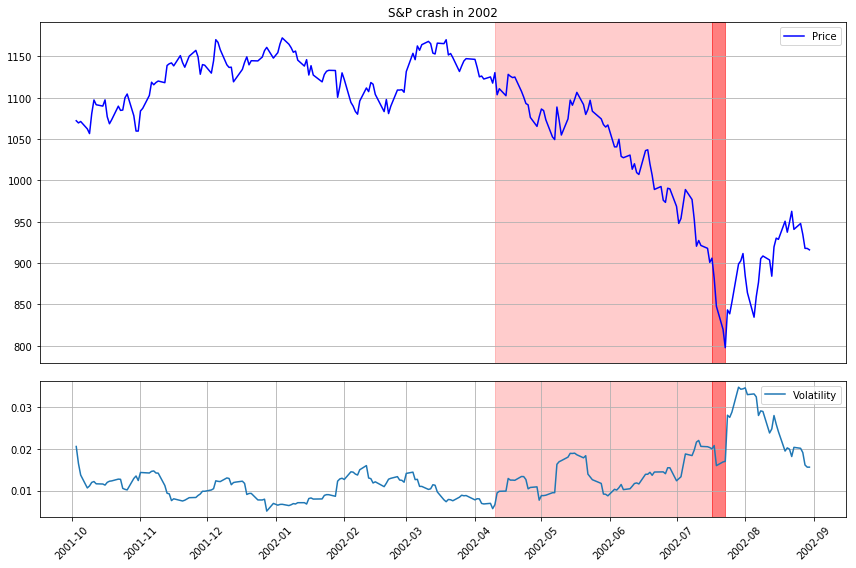

In [12]:
#2002 
plt.subplot(gs[0])
t1 = datetime.strptime('2001-10-03', '%Y-%m-%d')
t2 = datetime.strptime('2002-09-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.plot(sp.loc[t1:t2, 'price'], color='blue')
plt.title('S&P crash in 2002')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()


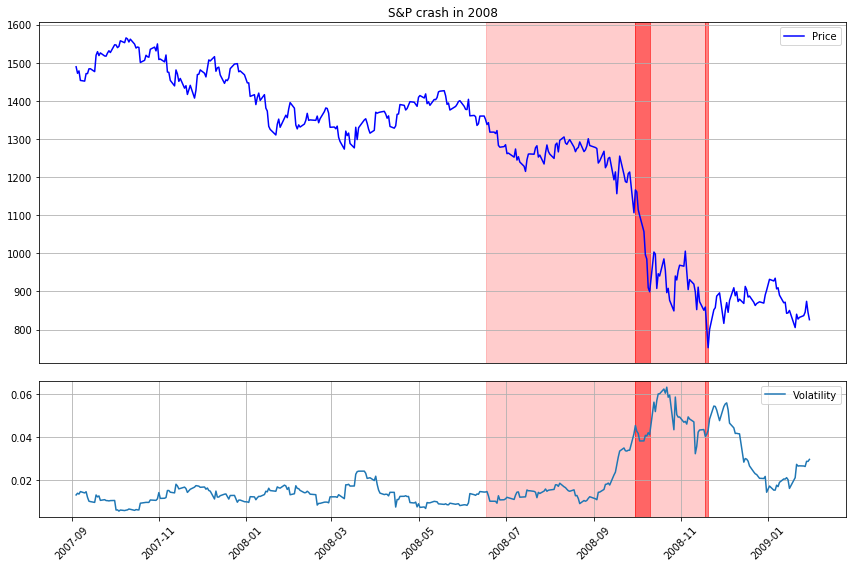

In [13]:
# 2008
plt.subplot(gs[0])
t1 = datetime.strptime('2007-09-01', '%Y-%m-%d')
t2 = datetime.strptime('2009-02-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.plot(sp.loc[t1:t2, 'price'], color='blue')
plt.title('S&P crash in 2008')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

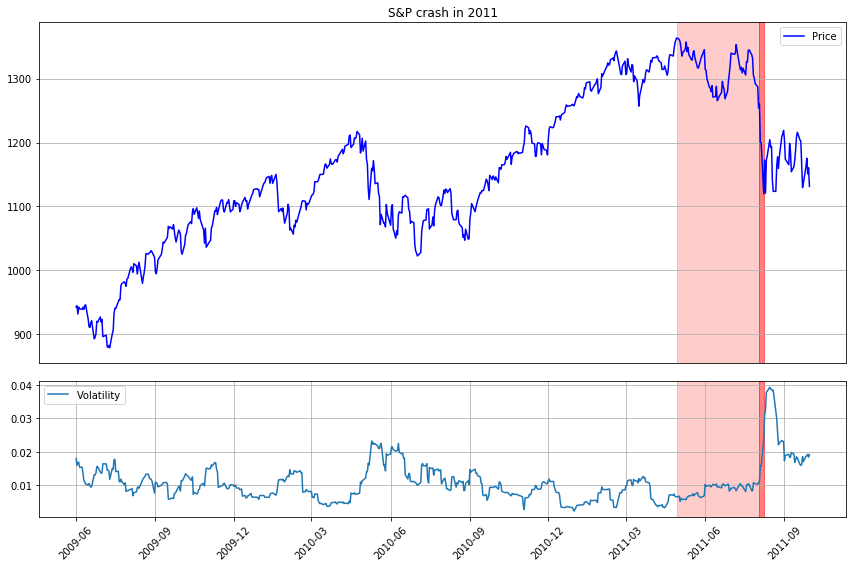

In [14]:
# 2011:
plt.subplot(gs[0])
t1 = datetime.strptime('2009-06-01', '%Y-%m-%d')
t2 = datetime.strptime('2011-10-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.plot(sp.loc[t1:t2, 'price'], color='blue')
plt.title('S&P crash in 2011')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

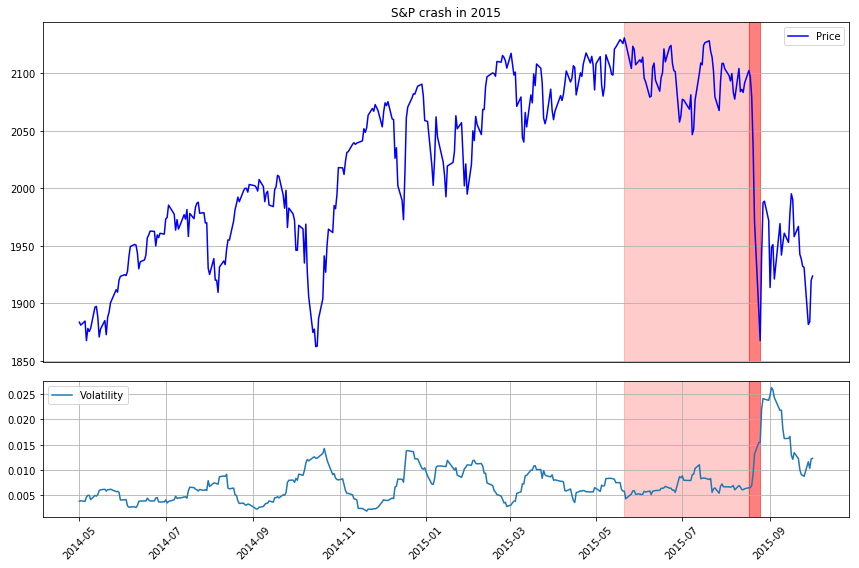

In [15]:
# 2015
plt.subplot(gs[0])
t1 = datetime.strptime('2014-05-01', '%Y-%m-%d')
t2 = datetime.strptime('2015-10-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.plot(sp.loc[t1:t2, 'price'], color='blue')
plt.title('S&P crash in 2015')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

In [16]:
####################### Multilinear regression
# training data: 1963 - 2018
# test data: 1952 - 1963
predictors = {}
outcomes = {}
for date in sp.index[252:]:
    pr_ch_12_6m = sp['ch'][(date-timedelta(252)):(date-timedelta(126))].mean()
    pr_ch_6_3m = sp['ch'][(date-timedelta(125)):(date-timedelta(63))].mean()
    pr_ch_3_2m = sp['ch'][(date-timedelta(62)):(date-timedelta(42))].mean()
    pr_ch_2_1m = sp['ch'][(date-timedelta(41)):(date-timedelta(21))].mean()
    pr_ch_4_3w = sp['ch'][(date-timedelta(20)):(date-timedelta(15))].mean()
    pr_ch_3_2w = sp['ch'][(date-timedelta(15)):(date-timedelta(10))].mean()
    pr_ch_2_1w = sp['ch'][(date-timedelta(10)):(date-timedelta(5))].mean()
    pr_ch_1_0w = sp['ch'][(date-timedelta(5)):(date-timedelta(0))].mean()
    vol_12_6m = sp['vol'][(date-timedelta(252)):(date-timedelta(126))].mean()
    vol_6_3m = sp['vol'][(date-timedelta(125)):(date-timedelta(63))].mean()
    vol_3_2m = sp['vol'][(date-timedelta(62)):(date-timedelta(42))].mean()
    vol_2_1m = sp['vol'][(date-timedelta(41)):(date-timedelta(21))].mean()
    vol_4_3w = sp['vol'][(date-timedelta(20)):(date-timedelta(15))].mean()
    vol_3_2w = sp['vol'][(date-timedelta(15)):(date-timedelta(10))].mean()
    vol_2_1w = sp['vol'][(date-timedelta(10)):(date-timedelta(5))].mean()
    vol_1_0w = sp['vol'][(date-timedelta(5)):(date-timedelta(0))].mean()
    predictors[date] = [pr_ch_12_6m, pr_ch_6_3m, pr_ch_3_2m, pr_ch_2_1m, pr_ch_4_3w, \
              pr_ch_3_2w, pr_ch_2_1w, pr_ch_1_0w, vol_12_6m, vol_6_3m, vol_3_2m, \
              vol_2_1m, vol_4_3w, vol_3_2w, vol_2_1w, vol_1_0w]
    d_6m = max([date <= d and date+timedelta(6*21) > d for d in df_c['down_st']])
    d_3m = max([date <= d and date+timedelta(3*21) > d for d in df_c['down_st']])
    d_1m = max([date <= d and date+timedelta(1*21) > d for d in df_c['down_st']])
    c_6m = max([date <= c and date+timedelta(6*21) > c for c in df_c['crash_st']])
    c_3m = max([date <= c and date+timedelta(3*21) > c for c in df_c['crash_st']])
    c_1m = max([date <= c and date+timedelta(1*21) > c for c in df_c['crash_st']])
    if max([date > d and date < c for d, c in zip(df_c['down_st'], df_c['crash_st'])]):
        d_6m=d_3m=d_1m=False
    outcomes[date] = [d_6m, d_3m, d_1m, c_6m, c_3m, c_1m]
df_pred = pd.DataFrame.from_dict(predictors, orient = 'index').dropna()
df_out = pd.DataFrame.from_dict(outcomes, orient = 'index').astype(int)
df_out = df_out.reindex(df_pred.index)
df_out.columns = ['d_6m', 'd_3m', 'd_1m', 'c_6m', 'c_3m', 'c_1m']

#train = sp.index['1963-01-01':'2018-03-01']
train_st = '1963-01-01'
train_end = '2018-03-01'
test_st = '1950-01-17'
test_end = '1963-01-01'
x_train = np.array(df_pred[train_st:train_end])
y_train = np.array(df_out[train_st:train_end])
x_test = np.array(df_pred[test_st:test_end])
y_test = np.array(df_out[test_st:test_end])

# train model - predict crash witin 6 months:
model = linear_model.LinearRegression()
model.fit(x_train, y_train[:,3])

# R-squared for crash within 6 months: 
print('R-squared: ', model.score(x_train, y_train[:,3]))

# predict on training data:
y_pred_train = model.predict(x_train)
y_pred_train_df = pd.DataFrame(y_pred_train)
y_pred_train_df.columns = ['c_6m']
y_pred_train_df.index = df_pred[train_st:train_end].index

# predict on test data:
y_pred_test = model.predict(x_test)
y_pred_test_df = pd.DataFrame(y_pred_test)
y_pred_test_df.columns = ['c_6m']
y_pred_test_df.index = df_pred[test_st:test_end].index

R-squared:  0.09131424022072954


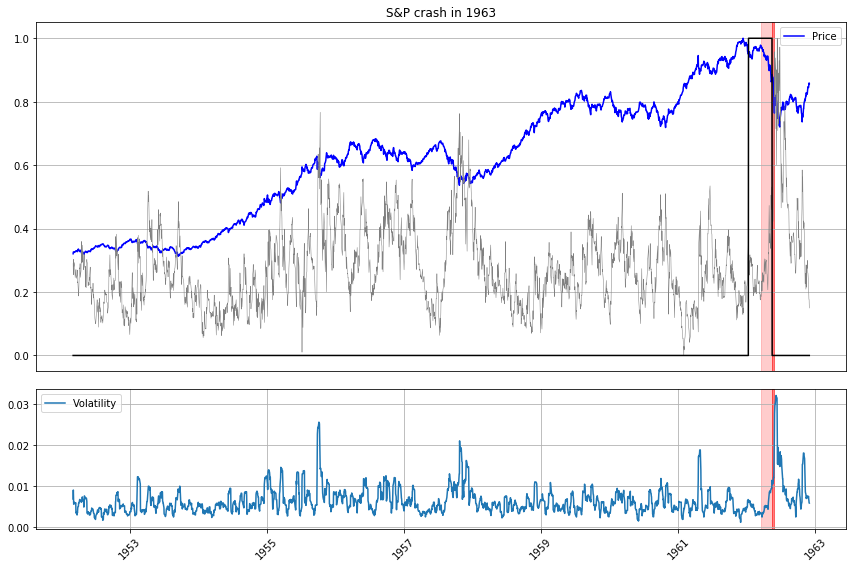

In [17]:
scaler = MinMaxScaler() 
plt.subplot(gs[0])
t1 = datetime.strptime('1952-03-01', '%Y-%m-%d')
t2 = datetime.strptime('1962-12-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
sp_norm = sp['price'][t1:t2] / sp['price'][t1:t2].max()
plt.plot(sp_norm[t1:t2], color='blue')
y_pred_test_df2 = y_pred_test_df
y_pred_test_df2.loc[t1:t2] = scaler.fit_transform(y_pred_test_df2[t1:t2]) 
plt.plot(y_pred_test_df.loc[t1:t2, 'c_6m'], color='gray', linewidth=0.5)
plt.plot(df_out.loc[t1:t2, 'c_6m'], color='black')
plt.title('S&P crash in 1963')
plt.xticks([])
plt.legend(['Price', 'Crash indicator', 'Before crash', 'Downturn/Crash'])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

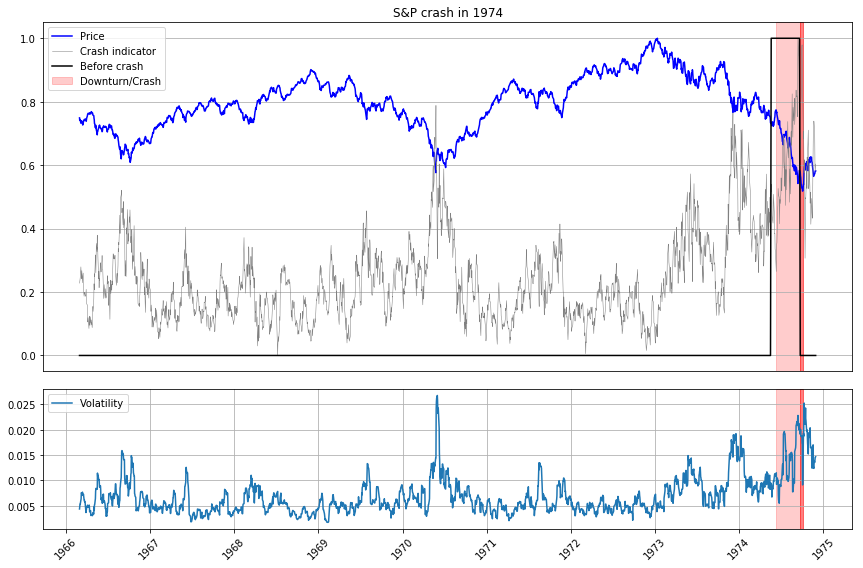

In [18]:
# 1974
plt.subplot(gs[0])
t1 = datetime.strptime('1966-03-01', '%Y-%m-%d')
t2 = datetime.strptime('1974-12-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
sp_norm = sp['price'][t1:t2] / sp['price'][t1:t2].max()
plt.plot(sp_norm[t1:t2], color='blue')
y_pred_train_df2 = y_pred_train_df
y_pred_train_df2.loc[t1:t2] = scaler.fit_transform(y_pred_train_df2[t1:t2]) 
plt.plot(y_pred_train_df.loc[t1:t2, 'c_6m'], color='gray', linewidth=0.5)
plt.plot(df_out.loc[t1:t2, 'c_6m'], color='black')
plt.title('S&P crash in 1974')
plt.xticks([])
plt.legend(['Price', 'Crash indicator', 'Before crash', 'Downturn/Crash'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()


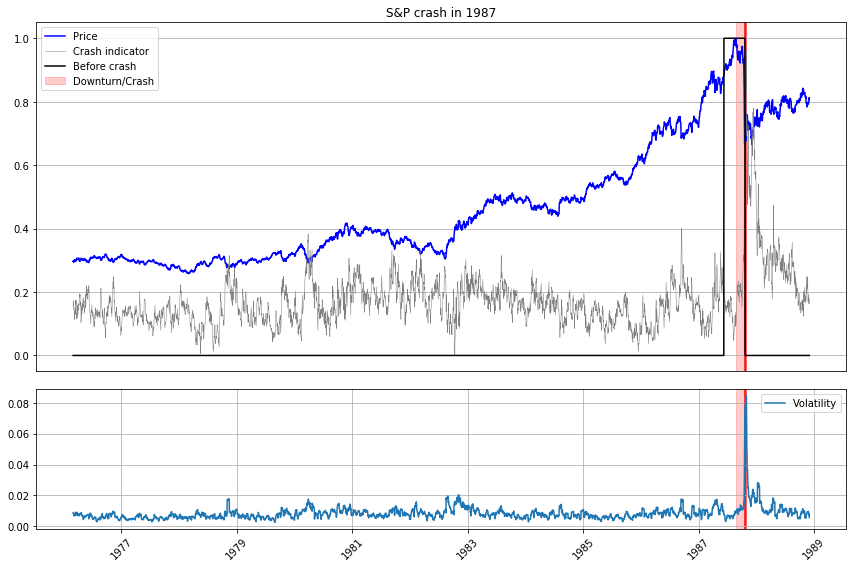

In [19]:
# 1987
plt.subplot(gs[0])
t1 = datetime.strptime('1976-03-01', '%Y-%m-%d')
t2 = datetime.strptime('1988-12-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
sp_norm = sp['price'][t1:t2] / sp['price'][t1:t2].max()
plt.plot(sp_norm[t1:t2], color='blue')
y_pred_train_df2 = y_pred_train_df
y_pred_train_df2.loc[t1:t2] = scaler.fit_transform(y_pred_train_df2[t1:t2]) 
plt.plot(y_pred_train_df.loc[t1:t2, 'c_6m'], color='gray', linewidth=0.5)
plt.plot(df_out.loc[t1:t2, 'c_6m'], color='black')
plt.title('S&P crash in 1987')
plt.xticks([])
plt.legend(['Price', 'Crash indicator', 'Before crash', 'Downturn/Crash'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()


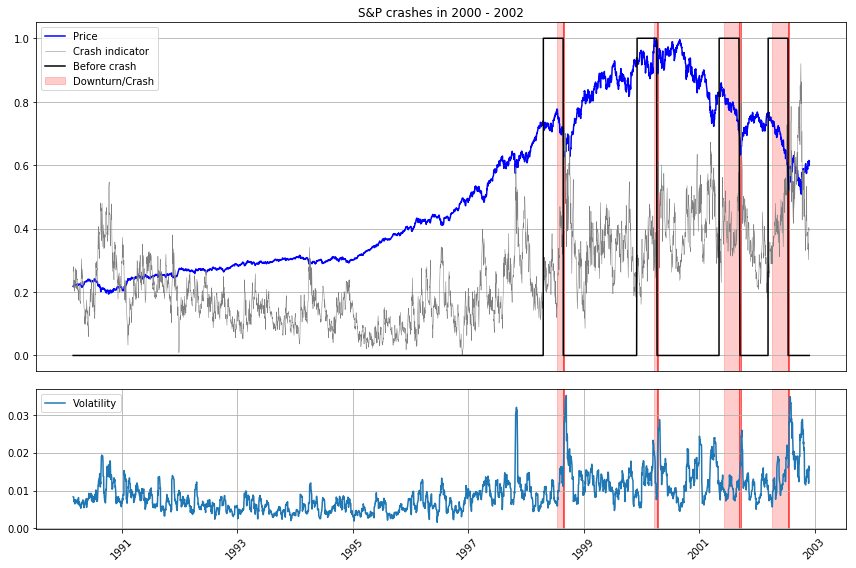

In [20]:
# 2000
plt.subplot(gs[0])
t1 = datetime.strptime('1990-03-01', '%Y-%m-%d')
t2 = datetime.strptime('2002-12-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
sp_norm = sp['price'][t1:t2] / sp['price'][t1:t2].max()
plt.plot(sp_norm[t1:t2], color='blue')
y_pred_train_df2 = y_pred_train_df
y_pred_train_df2.loc[t1:t2] = scaler.fit_transform(y_pred_train_df2[t1:t2]) 
plt.plot(y_pred_train_df.loc[t1:t2, 'c_6m'], color='gray', linewidth=0.5)
plt.plot(df_out.loc[t1:t2, 'c_6m'], color='black')
plt.title('S&P crashes in 2000 - 2002')
plt.xticks([])
plt.legend(['Price', 'Crash indicator', 'Before crash', 'Downturn/Crash'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

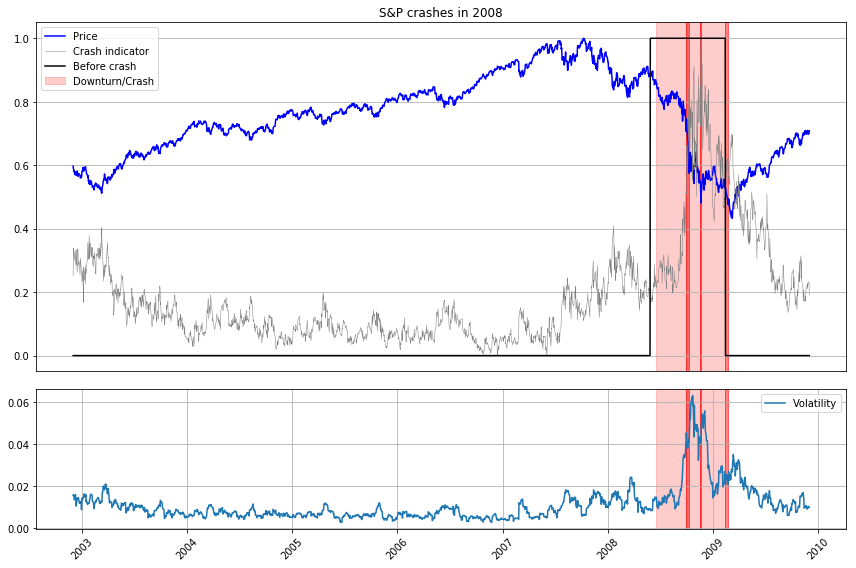

In [21]:
# 2008
plt.subplot(gs[0])
t1 = datetime.strptime('2002-12-01', '%Y-%m-%d')
t2 = datetime.strptime('2009-12-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
sp_norm = sp['price'][t1:t2] / sp['price'][t1:t2].max()
plt.plot(sp_norm[t1:t2], color='blue')
y_pred_train_df2 = y_pred_train_df
y_pred_train_df2.loc[t1:t2] = scaler.fit_transform(y_pred_train_df2[t1:t2]) 
plt.plot(y_pred_train_df.loc[t1:t2, 'c_6m'], color='gray', linewidth=0.5)
plt.plot(df_out.loc[t1:t2, 'c_6m'], color='black')
plt.title('S&P crashes in 2008')
plt.xticks([])
plt.legend(['Price', 'Crash indicator', 'Before crash', 'Downturn/Crash'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

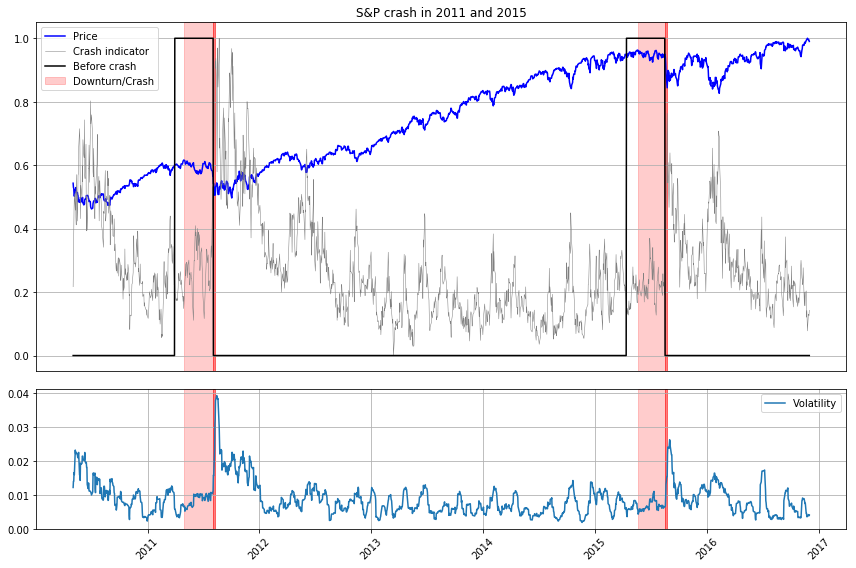

In [23]:
# 2011 and 2015
plt.subplot(gs[0])
t1 = datetime.strptime('2010-05-01', '%Y-%m-%d')
t2 = datetime.strptime('2016-12-01', '%Y-%m-%d')
down_st = list(filter(lambda x: x > t1 and x < t2, df_c['down_st']))
crash_st = list(filter(lambda x: x > t1 and x < t2, df_c['crash_st']))
crash_end = list(filter(lambda x: x > t1 and x < t2, df_c['crash_end']))
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
sp_norm = sp['price'][t1:t2] / sp['price'][t1:t2].max()
plt.plot(sp_norm[t1:t2], color='blue')
y_pred_train_df2 = y_pred_train_df
y_pred_train_df2.loc[t1:t2] = scaler.fit_transform(y_pred_train_df2[t1:t2]) 
plt.plot(y_pred_train_df.loc[t1:t2, 'c_6m'], color='gray', linewidth=0.5)
plt.plot(df_out.loc[t1:t2, 'c_6m'], color='black')
plt.title('S&P crash in 2011 and 2015')
plt.xticks([])
plt.legend(['Price', 'Crash indicator', 'Before crash', 'Downturn/Crash'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp.loc[t1:t2, 'vol'])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()